## Autoencoder

### Download Dataset

In [1]:
! pip install gdown
!gdown 18Z35ExJxuj8SNXEHrHmo07s07YEBO4C6

Downloading...
From (original): https://drive.google.com/uc?id=18Z35ExJxuj8SNXEHrHmo07s07YEBO4C6
From (redirected): https://drive.google.com/uc?id=18Z35ExJxuj8SNXEHrHmo07s07YEBO4C6&confirm=t&uuid=fc6b5093-a58e-4dc0-92fb-bba49112ae83
To: /content/creditcard.csv
100% 151M/151M [00:04<00:00, 33.5MB/s]


### Pre-Process

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

data = pd.read_csv('/content/creditcard.csv')

X = data.drop(columns=['Class'])
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=94)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=94)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)


### Define Autoencoder

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score

#  GPU OR CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transfer data to Tensor
X_train_tensor = torch.tensor(X_train_balanced, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_balanced.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

#  Autoencoder
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim1, encoding_dim2, encoding_dim3):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim1),
            nn.ReLU(),
            nn.Linear(encoding_dim1, encoding_dim2),
            nn.ReLU(),
            nn.Linear(encoding_dim2, encoding_dim3),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim3, encoding_dim2),
            nn.ReLU(),
            nn.Linear(encoding_dim2, encoding_dim1),
            nn.ReLU(),
            nn.Linear(encoding_dim1, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Classifier
class Classifier(nn.Module):
    def __init__(self, input_dim, encoding_dim1, encoding_dim2, encoding_dim3):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, encoding_dim1),
            nn.ReLU(),
            nn.Linear(encoding_dim1, encoding_dim2),
            nn.ReLU(),
            nn.Linear(encoding_dim2, encoding_dim3),
            nn.ReLU(),
            nn.Linear(encoding_dim3, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


### Train Model

In [ ]:
# تابع آموزش مدل
def train_autoencoder(autoencoder, train_loader, criterion, optimizer, num_epochs=100):
    autoencoder.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for data in train_loader:
            inputs, _ = data
            inputs = inputs.to(device)
            noisy_inputs = inputs + 0.1 * torch.randn_like(inputs).to(device)
            noisy_inputs = torch.clamp(noisy_inputs, 0., 1.)

            optimizer.zero_grad()
            outputs = autoencoder(noisy_inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# تابع آموزش مدل نهایی طبقه‌بندی
def train_classifier(classifier, train_loader, criterion, optimizer, num_epochs=100):
    classifier.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for data in train_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = classifier(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# تعریف و آموزش مدل Autoencoder
input_dim = X_train_balanced.shape[1]
encoding_dim1 = 22
encoding_dim2 = 15
encoding_dim3 = 10

autoencoder = DenoisingAutoencoder(input_dim, encoding_dim1, encoding_dim2, encoding_dim3).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

train_autoencoder(autoencoder, train_loader, criterion, optimizer, num_epochs=100)

# استخراج داده‌های نویزگیری شده
autoencoder.eval()
X_train_denoised = autoencoder(torch.tensor(X_train_balanced, dtype=torch.float32).to(device)).detach().cpu().numpy()
X_test_denoised = autoencoder(torch.tensor(X_test_scaled, dtype=torch.float32).to(device)).detach().cpu().numpy()

# تبدیل داده‌های نویزگیری شده به Tensor
X_train_denoised_tensor = torch.tensor(X_train_denoised, dtype=torch.float32).to(device)
X_test_denoised_tensor = torch.tensor(X_test_denoised, dtype=torch.float32).to(device)

train_denoised_dataset = TensorDataset(X_train_denoised_tensor, y_train_tensor)
test_denoised_dataset = TensorDataset(X_test_denoised_tensor, y_test_tensor)

train_denoised_loader = DataLoader(train_denoised_dataset, batch_size=256, shuffle=True)
test_denoised_loader = DataLoader(test_denoised_dataset, batch_size=256, shuffle=False)

# تعریف و آموزش مدل نهایی طبقه‌بندی
classifier = Classifier(input_dim, encoding_dim1, encoding_dim2, encoding_dim3).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

train_classifier(classifier, train_denoised_loader, criterion, optimizer, num_epochs=100)


Epoch [1/100], Loss: 10.7126
Epoch [2/100], Loss: 10.6218
Epoch [3/100], Loss: 10.6125
Epoch [4/100], Loss: 10.5920
Epoch [5/100], Loss: 10.5749
Epoch [6/100], Loss: 10.5657
Epoch [7/100], Loss: 10.5565
Epoch [8/100], Loss: 10.5464
Epoch [9/100], Loss: 10.5401
Epoch [10/100], Loss: 10.5359
Epoch [11/100], Loss: 10.5276
Epoch [12/100], Loss: 10.5233
Epoch [13/100], Loss: 10.5159
Epoch [14/100], Loss: 10.5129
Epoch [15/100], Loss: 10.5106
Epoch [16/100], Loss: 10.5082
Epoch [17/100], Loss: 10.5070
Epoch [18/100], Loss: 10.5064
Epoch [19/100], Loss: 10.5056
Epoch [20/100], Loss: 10.5052
Epoch [21/100], Loss: 10.5047
Epoch [22/100], Loss: 10.5045
Epoch [23/100], Loss: 10.5038
Epoch [24/100], Loss: 10.5029
Epoch [25/100], Loss: 10.5023
Epoch [26/100], Loss: 10.5020
Epoch [27/100], Loss: 10.5017
Epoch [28/100], Loss: 10.5015
Epoch [29/100], Loss: 10.5013
Epoch [30/100], Loss: 10.5011
Epoch [31/100], Loss: 10.5010
Epoch [32/100], Loss: 10.5008
Epoch [33/100], Loss: 10.5007
Epoch [34/100], Los

### Model Validation

In [ ]:

classifier.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for data in test_denoised_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        outputs = classifier(inputs)
        y_pred.extend(outputs.view(-1).tolist())
        y_true.extend(labels.tolist())

y_pred = np.array(y_pred) > 0.5
accuracy = accuracy_score(y_true, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')


Test Accuracy: 0.9127


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# تابع برای رسم ماتریس سردرگمی
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


Confusion Matrix:
[[51899  4965]
 [   10    88]]
Precision: 0.0174
Recall: 0.8980
Accuracy: 0.9127
F1-Score: 0.0342


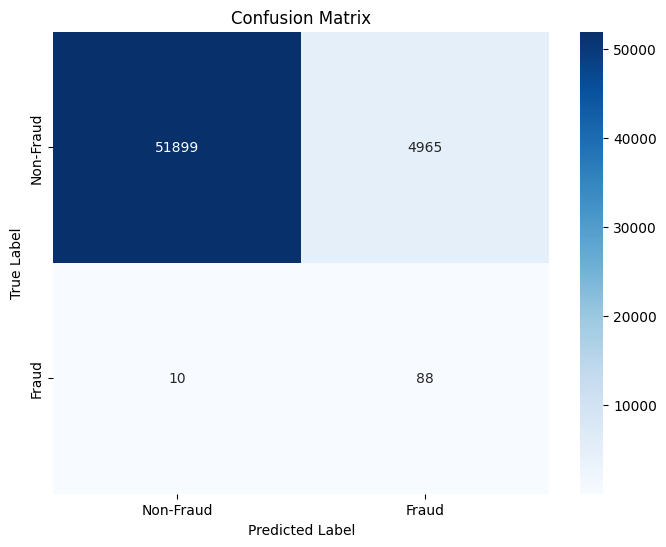

In [ ]:
classifier.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for data in test_denoised_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        outputs = classifier(inputs)
        y_pred.extend(outputs.view(-1).tolist())
        y_true.extend(labels.tolist())

y_pred = np.array(y_pred) > 0.5
y_true = np.array(y_true)

# محاسبه معیارها
cm = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f'Confusion Matrix:\n{cm}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'F1-Score: {f1:.4f}')

# رسم ماتریس سردرگمی
plot_confusion_matrix(cm, classes=['Non-Fraud', 'Fraud'])


### Train model with different thereshould range

Epoch [1/50], Loss: 4.2291
Epoch [2/50], Loss: 4.1548
Epoch [3/50], Loss: 4.1452
Epoch [4/50], Loss: 4.1416
Epoch [5/50], Loss: 4.1398
Epoch [6/50], Loss: 4.1328
Epoch [7/50], Loss: 4.1268
Epoch [8/50], Loss: 4.1214
Epoch [9/50], Loss: 4.1024
Epoch [10/50], Loss: 4.0984
Epoch [11/50], Loss: 4.0975
Epoch [12/50], Loss: 4.0938
Epoch [13/50], Loss: 4.0904
Epoch [14/50], Loss: 4.0879
Epoch [15/50], Loss: 4.0889
Epoch [16/50], Loss: 4.0757
Epoch [17/50], Loss: 4.0692
Epoch [18/50], Loss: 4.0701
Epoch [19/50], Loss: 4.0653
Epoch [20/50], Loss: 4.0653
Epoch [21/50], Loss: 4.0655
Epoch [22/50], Loss: 4.0630
Epoch [23/50], Loss: 4.0613
Epoch [24/50], Loss: 4.0595
Epoch [25/50], Loss: 4.0574
Epoch [26/50], Loss: 4.0545
Epoch [27/50], Loss: 4.0539
Epoch [28/50], Loss: 4.0504
Epoch [29/50], Loss: 4.0554
Epoch [30/50], Loss: 4.0535
Epoch [31/50], Loss: 4.0503
Epoch [32/50], Loss: 4.0501
Epoch [33/50], Loss: 4.0480
Epoch [34/50], Loss: 4.0489
Epoch [35/50], Loss: 4.0503
Epoch [36/50], Loss: 4.0498
E

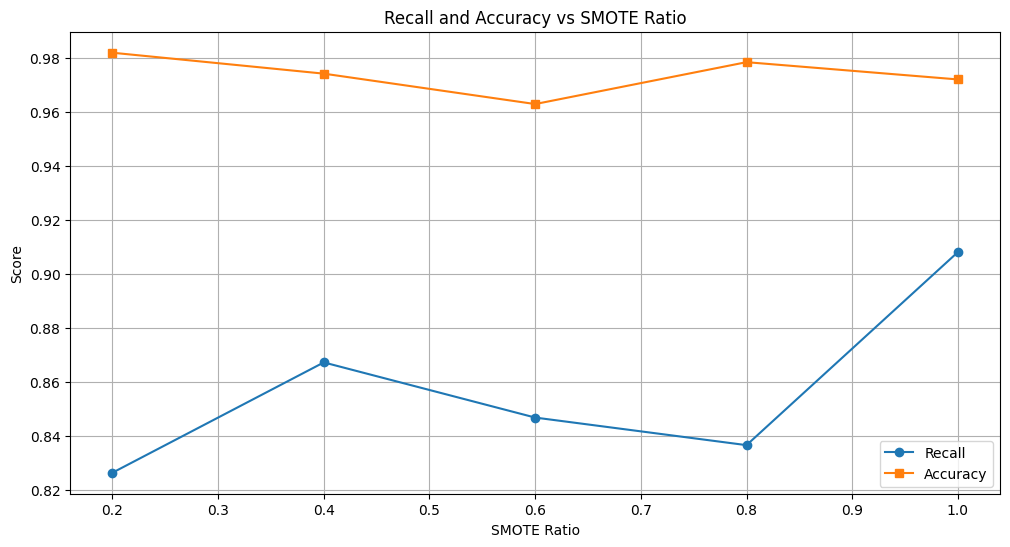

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

data = pd.read_csv('creditcard.csv')

X = data.drop(columns=['Class'])
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim1, encoding_dim2, encoding_dim3):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim1),
            nn.ReLU(),
            nn.Linear(encoding_dim1, encoding_dim2),
            nn.ReLU(),
            nn.Linear(encoding_dim2, encoding_dim3),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim3, encoding_dim2),
            nn.ReLU(),
            nn.Linear(encoding_dim2, encoding_dim1),
            nn.ReLU(),
            nn.Linear(encoding_dim1, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class Classifier(nn.Module):
    def __init__(self, input_dim, encoding_dim1, encoding_dim2, encoding_dim3):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, encoding_dim1),
            nn.ReLU(),
            nn.Linear(encoding_dim1, encoding_dim2),
            nn.ReLU(),
            nn.Linear(encoding_dim2, encoding_dim3),
            nn.ReLU(),
            nn.Linear(encoding_dim3, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

def train_autoencoder(autoencoder, train_loader, criterion, optimizer, num_epochs=100):
    autoencoder.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for data in train_loader:
            inputs, _ = data
            inputs = inputs.to(device)
            noisy_inputs = inputs + 0.1 * torch.randn_like(inputs).to(device)
            noisy_inputs = torch.clamp(noisy_inputs, 0., 1.)

            optimizer.zero_grad()
            outputs = autoencoder(noisy_inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

def train_classifier(classifier, train_loader, criterion, optimizer, num_epochs=100):
    classifier.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for data in train_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = classifier(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

smote_ratios = [0.2, 0.4, 0.6, 0.8, 1.0]
recall_scores = []
accuracy_scores = []

for ratio in smote_ratios:
    smote = SMOTE(sampling_strategy=ratio, random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

    X_train_tensor = torch.tensor(X_train_balanced, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_balanced.values, dtype=torch.float32).to(device)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

    input_dim = X_train_balanced.shape[1]
    encoding_dim1 = 22
    encoding_dim2 = 15
    encoding_dim3 = 10

    autoencoder = DenoisingAutoencoder(input_dim, encoding_dim1, encoding_dim2, encoding_dim3).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

    train_autoencoder(autoencoder, train_loader, criterion, optimizer, num_epochs=50)

    autoencoder.eval()
    X_train_denoised = autoencoder(torch.tensor(X_train_balanced, dtype=torch.float32).to(device)).detach().cpu().numpy()
    X_test_denoised = autoencoder(torch.tensor(X_test_scaled, dtype=torch.float32).to(device)).detach().cpu().numpy()

    X_train_denoised_tensor = torch.tensor(X_train_denoised, dtype=torch.float32).to(device)
    X_test_denoised_tensor = torch.tensor(X_test_denoised, dtype=torch.float32).to(device)

    train_denoised_dataset = TensorDataset(X_train_denoised_tensor, y_train_tensor)
    test_denoised_dataset = TensorDataset(X_test_denoised_tensor, y_test_tensor)

    train_denoised_loader = DataLoader(train_denoised_dataset, batch_size=256, shuffle=True)
    test_denoised_loader = DataLoader(test_denoised_dataset, batch_size=256, shuffle=False)

    classifier = Classifier(input_dim, encoding_dim1, encoding_dim2, encoding_dim3).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(classifier.parameters(), lr=0.001)

    train_classifier(classifier, train_denoised_loader, criterion, optimizer, num_epochs=5)

    classifier.eval()
    y_pred = []
    y_true = []

    with torch.no_grad():
        for data in test_denoised_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            outputs = classifier(inputs)
            y_pred.extend(outputs.view(-1).tolist())
            y_true.extend(labels.tolist())

    y_pred = np.array(y_pred) > 0.5
    y_true = np.array(y_true)

    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    recall_scores.append(recall)
    accuracy_scores.append(accuracy)

    print(f'SMOTE Ratio: {ratio}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}')

plt.figure(figsize=(12, 6))
plt.plot(smote_ratios, recall_scores, marker='o', label='Recall')
plt.plot(smote_ratios, accuracy_scores, marker='s', label='Accuracy')
plt.xlabel('SMOTE Ratio')
plt.ylabel('Score')
plt.title('Recall and Accuracy vs SMOTE Ratio')
plt.legend()
plt.grid()
plt.show()


###  unbalanced data and without noise removal

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# بارگیری داده‌ها
data = pd.read_csv('creditcard.csv')

# جدا کردن ویژگی‌ها و برچسب‌ها
X = data.drop(columns=['Class'])
y = data['Class']

# تقسیم داده‌ها به داده‌های آموزشی و تست
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# استانداردسازی داده‌ها
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# بررسی موجود بودن GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# تبدیل داده‌ها به Tensor
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# تعریف مدل طبقه‌بندی
class Classifier(nn.Module):
    def __init__(self, input_dim, encoding_dim1, encoding_dim2, encoding_dim3):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, encoding_dim1),
            nn.ReLU(),
            nn.Linear(encoding_dim1, encoding_dim2),
            nn.ReLU(),
            nn.Linear(encoding_dim2, encoding_dim3),
            nn.ReLU(),
            nn.Linear(encoding_dim3, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# تابع برای آموزش مدل طبقه‌بندی
def train_classifier(classifier, train_loader, criterion, optimizer, num_epochs=100):
    classifier.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for data in train_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = classifier(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# تعریف و آموزش مدل طبقه‌بندی
input_dim = X_train_scaled.shape[1]
encoding_dim1 = 22
encoding_dim2 = 15
encoding_dim3 = 10

classifier = Classifier(input_dim, encoding_dim1, encoding_dim2, encoding_dim3).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

train_classifier(classifier, train_loader, criterion, optimizer, num_epochs=50)

# ارزیابی مدل روی داده‌های تست
classifier.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        outputs = classifier(inputs)
        y_pred.extend(outputs.view(-1).tolist())
        y_true.extend(labels.tolist())

y_pred = np.array(y_pred) > 0.5
y_true = np.array(y_true)

# محاسبه معیارها
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f'Without SMOTE and Noise Removal - Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}')


Epoch [1/50], Loss: 0.0642
Epoch [2/50], Loss: 0.0034
Epoch [3/50], Loss: 0.0032
Epoch [4/50], Loss: 0.0030
Epoch [5/50], Loss: 0.0029
Epoch [6/50], Loss: 0.0027
Epoch [7/50], Loss: 0.0026
Epoch [8/50], Loss: 0.0025
Epoch [9/50], Loss: 0.0025
Epoch [10/50], Loss: 0.0024
Epoch [11/50], Loss: 0.0023
Epoch [12/50], Loss: 0.0023
Epoch [13/50], Loss: 0.0022
Epoch [14/50], Loss: 0.0022
Epoch [15/50], Loss: 0.0021
Epoch [16/50], Loss: 0.0020
Epoch [17/50], Loss: 0.0019
Epoch [18/50], Loss: 0.0018
Epoch [19/50], Loss: 0.0018
Epoch [20/50], Loss: 0.0017
Epoch [21/50], Loss: 0.0016
Epoch [22/50], Loss: 0.0017
Epoch [23/50], Loss: 0.0016
Epoch [24/50], Loss: 0.0015
Epoch [25/50], Loss: 0.0015
Epoch [26/50], Loss: 0.0015
Epoch [27/50], Loss: 0.0015
Epoch [28/50], Loss: 0.0014
Epoch [29/50], Loss: 0.0015
Epoch [30/50], Loss: 0.0014
Epoch [31/50], Loss: 0.0014
Epoch [32/50], Loss: 0.0014
Epoch [33/50], Loss: 0.0013
Epoch [34/50], Loss: 0.0013
Epoch [35/50], Loss: 0.0013
Epoch [36/50], Loss: 0.0012
E

### With remove noise

In [6]:
# افزایش داده‌ها با استفاده از SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# تبدیل داده‌های SMOTE به Tensor
X_train_tensor_smote = torch.tensor(X_train_balanced, dtype=torch.float32).to(device)
y_train_tensor_smote = torch.tensor(y_train_balanced.values, dtype=torch.float32).to(device)

train_dataset_smote = TensorDataset(X_train_tensor_smote, y_train_tensor_smote)
train_loader_smote = DataLoader(train_dataset_smote, batch_size=256, shuffle=True)

# تعریف مدل Autoencoder
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim1, encoding_dim2, encoding_dim3):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim1),
            nn.ReLU(),
            nn.Linear(encoding_dim1, encoding_dim2),
            nn.ReLU(),
            nn.Linear(encoding_dim2, encoding_dim3),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim3, encoding_dim2),
            nn.ReLU(),
            nn.Linear(encoding_dim2, encoding_dim1),
            nn.ReLU(),
            nn.Linear(encoding_dim1, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# تابع برای آموزش مدل Autoencoder
def train_autoencoder(autoencoder, train_loader, criterion, optimizer, num_epochs=100):
    autoencoder.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for data in train_loader:
            inputs, _ = data
            inputs = inputs.to(device)
            noisy_inputs = inputs + 0.1 * torch.randn_like(inputs).to(device)
            noisy_inputs = torch.clamp(noisy_inputs, 0., 1.)

            optimizer.zero_grad()
            outputs = autoencoder(noisy_inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# تعریف و آموزش مدل Autoencoder
autoencoder = DenoisingAutoencoder(input_dim, encoding_dim1, encoding_dim2, encoding_dim3).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

train_autoencoder(autoencoder, train_loader_smote, criterion, optimizer, num_epochs=50)

# استخراج داده‌های نویزگیری شده
autoencoder.eval()
X_train_denoised = autoencoder(torch.tensor(X_train_balanced, dtype=torch.float32).to(device)).detach().cpu().numpy()
X_test_denoised = autoencoder(torch.tensor(X_test_scaled, dtype=torch.float32).to(device)).detach().cpu().numpy()

# تبدیل داده‌های نویزگیری شده به Tensor
X_train_denoised_tensor = torch.tensor(X_train_denoised, dtype=torch.float32).to(device)
X_test_denoised_tensor = torch.tensor(X_test_denoised, dtype=torch.float32).to(device)

train_denoised_dataset = TensorDataset(X_train_denoised_tensor, y_train_tensor_smote)
test_denoised_dataset = TensorDataset(X_test_denoised_tensor, y_test_tensor)

train_denoised_loader = DataLoader(train_denoised_dataset, batch_size=256, shuffle=True)
test_denoised_loader = DataLoader(test_denoised_dataset, batch_size=256, shuffle=False)

# تعریف و آموزش مدل نهایی طبقه‌بندی
classifier_smote = Classifier(input_dim, encoding_dim1, encoding_dim2, encoding_dim3).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(classifier_smote.parameters(), lr=0.001)

train_classifier(classifier_smote, train_denoised_loader, criterion, optimizer, num_epochs=50)

# ارزیابی مدل روی داده‌های تست
classifier_smote.eval()
y_pred_smote = []
y_true_smote = []

with torch.no_grad():
    for data in test_denoised_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        outputs = classifier_smote(inputs)
        y_pred_smote.extend(outputs.view(-1).tolist())
        y_true_smote.extend(labels.tolist())

y_pred_smote = np.array(y_pred_smote) > 0.5
y_true_smote = np.array(y_true_smote)

# محاسبه معیارها
precision_smote = precision_score(y_true_smote, y_pred_smote)
recall_smote = recall_score(y_true_smote, y_pred_smote)
accuracy_smote = accuracy_score(y_true_smote, y_pred_smote)
f1_smote = f1_score(y_true_smote, y_pred_smote)

# نمایش نتایج
print(f'With SMOTE and Noise Removal - Precision: {precision_smote:.4f}, Recall: {recall_smote:.4f}, Accuracy: {accuracy_smote:.4f}, F1-Score: {f1_smote:.4f}')


Epoch [1/50], Loss: 10.5738
Epoch [2/50], Loss: 10.4944
Epoch [3/50], Loss: 10.4722
Epoch [4/50], Loss: 10.4441
Epoch [5/50], Loss: 10.4221
Epoch [6/50], Loss: 10.4058
Epoch [7/50], Loss: 10.3871
Epoch [8/50], Loss: 10.3735
Epoch [9/50], Loss: 10.3639
Epoch [10/50], Loss: 10.3587
Epoch [11/50], Loss: 10.3560
Epoch [12/50], Loss: 10.3536
Epoch [13/50], Loss: 10.3525
Epoch [14/50], Loss: 10.3515
Epoch [15/50], Loss: 10.3477
Epoch [16/50], Loss: 10.3315
Epoch [17/50], Loss: 10.3260
Epoch [18/50], Loss: 10.3212
Epoch [19/50], Loss: 10.3193
Epoch [20/50], Loss: 10.3179
Epoch [21/50], Loss: 10.3162
Epoch [22/50], Loss: 10.3118
Epoch [23/50], Loss: 10.3015
Epoch [24/50], Loss: 10.2968
Epoch [25/50], Loss: 10.2952
Epoch [26/50], Loss: 10.2941
Epoch [27/50], Loss: 10.2914
Epoch [28/50], Loss: 10.2890
Epoch [29/50], Loss: 10.2875
Epoch [30/50], Loss: 10.2867
Epoch [31/50], Loss: 10.2858
Epoch [32/50], Loss: 10.2849
Epoch [33/50], Loss: 10.2843
Epoch [34/50], Loss: 10.2840
Epoch [35/50], Loss: 10

In [7]:
print(f'Without SMOTE and Noise Removal - Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}')

print(f'With SMOTE and Noise Removal - Precision: {precision_smote:.4f}, Recall: {recall_smote:.4f}, Accuracy: {accuracy_smote:.4f}, F1-Score: {f1_smote:.4f}')


Without SMOTE and Noise Removal - Precision: 0.8021, Recall: 0.7857, Accuracy: 0.9993, F1-Score: 0.7938
With SMOTE and Noise Removal - Precision: 0.0333, Recall: 0.8673, Accuracy: 0.9564, F1-Score: 0.0641
